In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

from models.multi_task_model import MultiTaskModel
from data.taskonomy_replica_gso_dataset import TaskonomyReplicaGsoDataset

In [13]:
# settings
tasks = ['reshading']
# tasks = ['rgb', 'normal', 'segment_semantic', 'edge_occlusion', 'edge_texture', 'keypoints3d', 'depth_zbuffer', 'mask_valid']
taskonomy_variant = 'full'
batch_size = 1
image_size = 512
normalize_rgb = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataloaders

In [14]:
opt_test_taskonomy = TaskonomyReplicaGsoDataset.Options(
    split='train',
    taskonomy_variant=taskonomy_variant,
    tasks=tasks,
    datasets=['taskonomy'],
    transform='DEFAULT',
    image_size=image_size,
    normalize_rgb=normalize_rgb,
    randomize_views=False
)

testset_taskonomy = TaskonomyReplicaGsoDataset(options=opt_test_taskonomy)

opt_test_replica = TaskonomyReplicaGsoDataset.Options(
    split='train',
    taskonomy_variant=taskonomy_variant,
    tasks=tasks,
    datasets=['replica'],
    transform='DEFAULT',
    image_size=image_size,
    normalize_rgb=normalize_rgb,
    randomize_views=False
)

testset_replica = TaskonomyReplicaGsoDataset(options=opt_test_replica)

opt_test_hypersim = TaskonomyReplicaGsoDataset.Options(
    split='train',
    taskonomy_variant=taskonomy_variant,
    tasks=tasks,
    datasets=['hypersim'],
    transform='DEFAULT',
    image_size=image_size,
    normalize_rgb=normalize_rgb,
    randomize_views=False
)

testset_hypersim = TaskonomyReplicaGsoDataset(options=opt_test_hypersim)

opt_train_gso = TaskonomyReplicaGsoDataset.Options(
    tasks=tasks,
    datasets=['gso'],
    split='train',
    taskonomy_variant=taskonomy_variant,
    transform='DEFAULT',
    image_size=image_size,
    normalize_rgb=normalize_rgb,
    randomize_views=True
)
testset_gso = TaskonomyReplicaGsoDataset(options=opt_train_gso)


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ./tmp/taskonomy_reshading_full-train.pkl
!! here
Loaded taskonomy with 2877885 images from tmp.
!!!!!!!!!!!! rgb :  0
!!!!!!!!!!!! semantic segmentation :  0


Loaded 2877885 images in 18.51 seconds
	 (342 buildings) (428520 points) (2877885 images) for domains ['reshading']


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ./tmp/replica_reshading_train.pkl
!! here
Loaded replica with 56783 images from tmp.
!!!!!!!!!!!! rgb :  0
!!!!!!!!!!!! semantic segmentation :  0


Loaded 56783 images in 0.22 seconds
	 (10 buildings) (2372 points) (56783 images) for domains ['reshading']


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ./tmp/hypersim_reshading_train.pkl
!! here
Loaded hypersim with 57491 images from tmp.
!!!!!!!!!!!! rgb :  0
!!!!!!!!!!!! semantic segmentation :  0


Loaded 57491 images in 0.32 seconds
	 (605 buildings) (57491 points) (57491 images) for domains ['reshading']


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  ./tmp/gso_reshading_train.pkl
!! here
Loaded gso with 107404 images from tmp.
!!!!!!!!!!!! rgb :  0
!!!!!!!!!!!! semantic segmentation :  0


Loaded 107404 images in 2.43 seconds
	 (30 buildings) (8767 points) (107404 images) for domains ['reshading']


In [15]:
testset_taskonomy.randomize_order(seed=99)
testset_replica.randomize_order(seed=99)
testset_hypersim.randomize_order(seed=99)
testset_gso.randomize_order(seed=99)

subset = list(range(0, 20000))
taskonomy = torch.utils.data.Subset(testset_taskonomy, subset)
replica = torch.utils.data.Subset(testset_replica, subset)
hypersim = torch.utils.data.Subset(testset_hypersim, subset)
gso = torch.utils.data.Subset(testset_gso, subset)

dataloader_combined = DataLoader(
    ConcatDataset([taskonomy]), # , replica, hypersim, gso
    batch_size=batch_size, shuffle=False, num_workers=32, pin_memory=False
)

In [16]:
test_dataloader_taskonomy = DataLoader(
    testset_taskonomy, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False
)
test_dataloader_replica = DataLoader(
    testset_replica, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False
)
test_dataloader_hypersim = DataLoader(
    testset_hypersim, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False
)
test_dataloader_gso = DataLoader(
    testset_gso, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False
)
test_dataloader_combined = DataLoader(
    ConcatDataset([testset_taskonomy, testset_replica, testset_hypersim, testset_gso]), 
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False
)


In [17]:
# print(len(test_dataloader_taskonomy))
# print(len(test_dataloader_replica))
# print(len(test_dataloader_hypersim))
# print(len(test_dataloader_gso))
# print(len(test_dataloader_combined))
print(len(dataloader_combined))

20000


# Utils

In [18]:
def make_valid_mask(mask_float, max_pool_size=4, return_small_mask=False):
    '''
        Creates a mask indicating the valid parts of the image(s).
        Enlargens masked area using a max pooling operation.

        Args:
            mask_float: A mask as loaded from the Taskonomy loader.
            max_pool_size: Parameter to choose how much to enlarge masked area.
            return_small_mask: Set to true to return mask for aggregated image
    '''
    if len(mask_float.shape) == 3:
        mask_float = mask_float.unsqueeze(axis=0)
    reshape_temp = len(mask_float.shape) == 5
    if reshape_temp:
        mask_float = rearrange(mask_float, 'b p c h w -> (b p) c h w')
    mask_float = 1 - mask_float
    mask_float = F.max_pool2d(mask_float, kernel_size=max_pool_size)
    mask_float = F.interpolate(mask_float, (image_size, image_size), mode='nearest')
    mask_valid = mask_float == 0
    if reshape_temp:
        mask_valid = rearrange(mask_valid, '(b p) c h w -> b p c h w', p=1)

    return mask_valid

In [19]:
class MedianImageMeter(object):
    def __init__(self, bit_depth, im_shape, device='cpu'):
        self.bit_depth = bit_depth
        self.im_shape = list(im_shape)
        self.device = device
        if bit_depth == 8:
            self.dtype = np.uint8
        elif bit_depth == 16:
            self.dtype = np.uint16
        else:
            raise NotImplementedError(
                "MedianMeter cannot find the median of non 8/16 bit-depth images.")
        self.reset() 
        
        print("!!!!!!!!1 ", self.freqs.shape)
        
    def reset(self):
        self.freqs = self.make_freqs_array()  
        
    def add(self, val, mask=1):
        self.val = torch.LongTensor( val.astype(np.int64).flatten()[np.newaxis,:] ).to(self.device)  
        if type(mask) == int:
            mask = torch.IntTensor(self.val.size()).fill_(mask).to(self.device)

        else:
            mask = torch.IntTensor(mask.astype(np.int32).flatten()[np.newaxis,:]).to(self.device) 
            
        self.freqs.scatter_add_(0, self.val, mask) 
        self.saved_val = val    
        
    def value(self):
        self._avg = np.cumsum(
                        self.freqs.cpu().numpy(), 
                        axis=0)
        self._avg = np.apply_along_axis(
                        lambda a: a.searchsorted(a[-1] / 2.), 
                        axis=0, 
                        arr=self._avg)\
                    .reshape(tuple([-1] + self.im_shape))
        return np.squeeze(self._avg, 0)    
    
    def make_freqs_array(self):
        # freqs has shape N_categories x W x H x N_channels 
        shape = tuple([2**self.bit_depth] + self.im_shape)
        freqs = torch.IntTensor(shape[0], int(np.prod(shape[1:]))).zero_()
        return freqs.to(self.device)

In [20]:
class MedianImageMeter(object):
    def __init__(self, bit_depth, im_shape, device='cpu'):
        self.bit_depth = bit_depth
        self.im_shape = list(im_shape)
        self.device = device
        if bit_depth == 8:
            self.dtype = np.uint8
        elif bit_depth == 16:
            self.dtype = np.uint16
        else:
            raise NotImplementedError(
                "MedianMeter cannot find the median of non 8/16 bit-depth images.")
        self.reset() 
        
        
    def reset(self):
        self.freqs = self.make_freqs_array()  
        
    def add(self, val, mask=1):
        self.val = torch.LongTensor( val.long().flatten()[np.newaxis,:] ).cuda()
        
        if type(mask) == int:
            mask = torch.IntTensor(self.val.size()).fill_(mask).cuda()

        else:
            mask = torch.IntTensor(mask.astype(np.int32).flatten()[np.newaxis,:]).cuda()
            
        self.freqs.scatter_add_(0, self.val, mask) 
        
        self.saved_val = val    
        
        
    def value(self):
        self._avg = np.cumsum(
                        self.freqs.cpu().numpy(), 
                        axis=0)
        self._avg = np.apply_along_axis(
                        lambda a: a.searchsorted(a[-1] / 2.), 
                        axis=0, 
                        arr=self._avg)\
                    .reshape(tuple([-1] + self.im_shape))
        return np.squeeze(self._avg, 0)    
    
    def make_freqs_array(self):
        # freqs has shape N_categories x W x H x N_channels 
        shape = tuple([2**self.bit_depth] + self.im_shape)
        freqs = torch.IntTensor(shape[0], int(np.prod(shape[1:]))).zero_()
        return freqs.to(self.device)

In [21]:
m=MedianImageMeter(8, (3, image_size, image_size), device=device)

with torch.no_grad():
    for step, batch in enumerate(dataloader_combined):
        print(step)
        normal = batch['positive']['reshading']
        m.add(normal[0] * 255)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077


3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720


5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360


6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031


8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685


10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
1027

11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
1163

12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
1302

14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
1440

15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
1577

16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
1713

18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
1854

19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
1991

In [22]:
val = m.value()


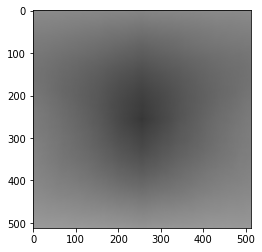

In [23]:
from PIL import Image
val_hypersim = np.uint8(val.transpose([1,2,0]))
im = Image.fromarray(val_hypersim)
im.save('/scratch/ainaz/omnidata2/blind_guesses/reshading_taskonomy.png')
plt.imshow(np.uint8(val.transpose([1,2,0])))

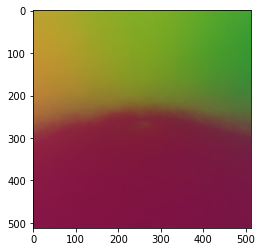

In [15]:
from PIL import Image
val_hypersim = np.uint8(val.transpose([1,2,0]))
im = Image.fromarray(val_hypersim)
im.save('/scratch/ainaz/omnidata2/blind_guesses/normal_combined.png')
plt.imshow(np.uint8(val.transpose([1,2,0])))

In [94]:
import pandas as pd
d = {
    'Kernel Size': [3, 3, 5, 5, 7, 7, 9, 9],
    'Training Procedure': ['With Augmentation', 'Without Augmentation', 
                               'With Augmentation', 'Without Augmentation',
                               'With Augmentation', 'Without Augmentation',
                                'With Augmentation', 'Without Augmentation'],
    'Accuracy within 11.25°': [78.78, 75.06, 78.08, 69.26, 77.78, 66.93, 77.66, 66.48]}
df = pd.DataFrame(data=d)
df

,Kernel Size,Training Procedure,Accuracy within 11.25°
0,3,With Augmentation,78.78
1,3,Without Augmentation,75.06
2,5,With Augmentation,78.08
3,5,Without Augmentation,69.26
4,7,With Augmentation,77.78
5,7,Without Augmentation,66.93
6,9,With Augmentation,77.66
7,9,Without Augmentation,66.48


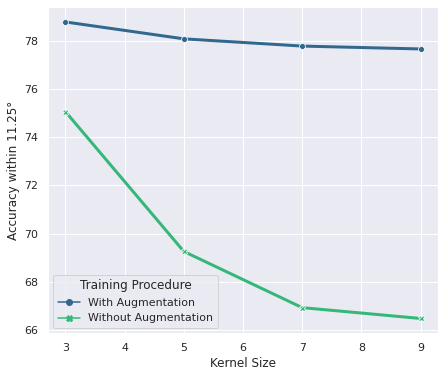

In [95]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# sns.color_palette("hls", 8)
# sns.color_palette("Paired")
# sns.color_palette("viridis", as_cmap=True)
sns.set(rc={'figure.figsize':(7,6)})
sns.color_palette("Spectral")
sns_plot = sns.lineplot(data=df, x="Kernel Size", y="Accuracy within 11.25°", hue="Training Procedure",
              palette='viridis', linewidth=3, markers=True, dashes=False, style="Training Procedure", ci=68)
plt.savefig("/scratch/ainaz/omnidata2/acc_plot.pdf")

# sns_plot.figure.savefig("/scratch/ainaz/omnidata2/acc_plot.png")

In [98]:
import pandas as pd
d = {
    'Kernel Size': [3, 3, 5, 5, 7, 7, 9, 9],
    'Training Procedure': ['With Augmentation', 'Without Augmentation', 
                               'With Augmentation', 'Without Augmentation',
                               'With Augmentation', 'Without Augmentation',
                                'With Augmentation', 'Without Augmentation'],
    'Mean Angular Error': [7.7, 9.1, 7.95, 11.04, 8.07, 11.83, 8.12, 11.99]}
df = pd.DataFrame(data=d)
df

,Kernel Size,Training Procedure,Mean Angular Error
0,3,With Augmentation,7.70
1,3,Without Augmentation,9.10
2,5,With Augmentation,7.95
3,5,Without Augmentation,11.04
4,7,With Augmentation,8.07
5,7,Without Augmentation,11.83
6,9,With Augmentation,8.12
7,9,Without Augmentation,11.99


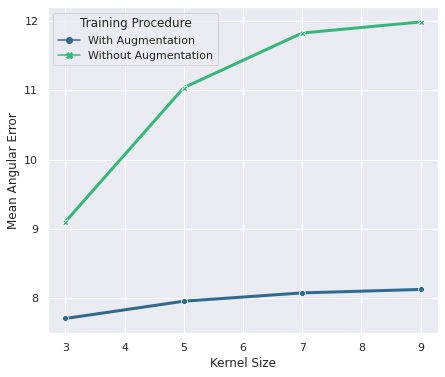

In [99]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# sns.color_palette("hls", 8)
# sns.color_palette("Paired")
# sns.color_palette("viridis", as_cmap=True)
sns.set(rc={'figure.figsize':(7,6)})
sns.color_palette("rocket_r")
sns_plot = sns.lineplot(data=df, x="Kernel Size", y="Mean Angular Error", hue="Training Procedure",
              palette='viridis', linewidth=3, markers=True, dashes=False, style="Training Procedure", ci=68)
plt.savefig("/scratch/ainaz/omnidata2/error_plot.pdf")
# sns_plot.figure.savefig("/scratch/ainaz/omnidata2/error_plot.png")